# **Segmentation and classification of pathologies in medical images using artificial neural networks**

**Dataset: BraTS2020**

In [ ]:
!git clone https://github.com/mwarylak/BraTS_Thesis.git

In [ ]:
!pip install kaggle
!pip install torchview

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision.models as models
import albumentations as A
import torch.nn.functional as F
import cv2
import random
from torchview import draw_graph
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt

In [ ]:
!kaggle datasets download -d awsaf49/brats2020-training-data
!unzip brats2020-training-data.zip

In [ ]:
directory = "/content/BraTS2020_training_data/content/data"
test_directory = '/content/BraTS_Thesis/Files/Test_Samples'

h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
plt.rcParams['text.color']       = '#545353'

augmentation_types = [] #available augmentation type: NEC_ET, random, mixup lub cutmix
normalization = '' #available normalization type: min-max, z-score lub percent

with open("/content/BraTS_Thesis/Files/h5files.txt", "r") as file:
    lesion_files = [line.strip() for line in file]

In [6]:
def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()

def overlay_masks(image, mask, alpha=0.5, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)

    color_mask = np.zeros_like(rgb_image)
    color_mask[..., 0] = mask[0, :, :]
    color_mask[..., 1] = mask[1, :, :]
    color_mask[..., 2] = mask[2, :, :]

    rgb_image = (1 - alpha) * rgb_image + alpha * color_mask

    return rgb_image

def display_side_by_side(image, pred_mask, mask, title="Prediction Overlay"):
    overlay_pred = overlay_masks(image, pred_mask)
    overlay_mask = overlay_masks(image, mask)

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(overlay_pred)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_mask)
    plt.title('Brain MRI with Tumour Masks Overlay', fontsize=18, y=1.02)
    plt.axis('off')

    plt.show()

# **Dataset**

In [ ]:
def augment_lesion(image, mask):
    augmentation = A.Compose([
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.ElasticTransform(p=0.5),
        A.OpticalDistortion(p=0.5),
        A.GaussianBlur(blur_limit=(3, 9), p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, p=0.5),
    ], is_check_shapes=False)

    try:
        augmented = augmentation(image=image, mask=mask)
        augmented_images = augmented['image']
        augmented_masks = augmented['mask']
    except Exception as e:
        augmented_images = image
        augmented_masks = mask

    return augmented_images, augmented_masks

def NEC_ET_augmentation(sample, directory, new_directory):

        file_path = os.path.join(directory, sample)
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]

        nec_mask = mask[:, :, 0]
        nec_non_zero_value = np.count_nonzero(nec_mask)
        ed_mask = mask[:, :, 1]
        ed_non_zero_value = np.count_nonzero(ed_mask)
        et_mask = mask[:, :, 2]
        et_non_zero_value = np.count_nonzero(et_mask)

        new_file_path = ''

        if nec_non_zero_value > ed_non_zero_value or et_non_zero_value > ed_non_zero_value:

            combined_mask = nec_mask + et_mask
            non_zero_indices = np.where(combined_mask != 0)

            y_min, y_max = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
            x_min, x_max = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])
            bounding_box = (y_min, y_max, x_min, x_max)

            cropped_image = image[y_min:y_max, x_min:x_max, :]
            cropped_mask = mask[y_min:y_max, x_min:x_max, :]

            aug_image, aug_mask = augment_lesion(cropped_image, cropped_mask)

            new_image = image.copy()
            new_mask = mask.copy()
            new_image[y_min:y_max, x_min:x_max, :] = aug_image
            new_mask[y_min:y_max, x_min:x_max, :] = aug_mask

            new_file_name = f"{os.path.basename(file_path).replace('.h5', '')}_lesion_aug.h5"
            new_file_path = os.path.join(new_directory, new_file_name)
            with h5py.File(new_file_path, 'w') as new_file:
                new_file.create_dataset('image', data=new_image)
                new_file.create_dataset('mask', data=new_mask)

        return new_file_path

def augment_image_and_mask(image, mask):
    augmentation = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=25, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ElasticTransform(p=0.5),
        A.OpticalDistortion(p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5)
    ], is_check_shapes=False)

    try:
        augmented = augmentation(image=image, mask=mask)
        augmented_images = augmented['image']
        augmented_masks = augmented['mask']
    except Exception as e:
        augmented_images = image
        augmented_masks = mask

    return augmented_images, augmented_masks

def random_augmentation(sample, directory, new_directory):
        if not os.path.exists(new_directory):
            os.makedirs(new_directory)

        file_path = os.path.join(directory, sample)
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]

        new_file_path = ''

        if np.any(mask != 0):

          aug_image, aug_mask = augment_image_and_mask(image, mask)

          new_file_name = f"{os.path.basename(file_path).replace('.h5', '')}_aug.h5"
          new_file_path = os.path.join(new_directory, new_file_name)
          with h5py.File(new_file_path, 'w') as new_file:
              new_file.create_dataset('image', data=aug_image)
              new_file.create_dataset('mask', data=aug_mask)

        return new_file_path

def mixup(image1, mask1, image2, mask2, alpha=0.4):
    lam = np.random.beta(alpha, alpha)

    new_image = lam * image1 + (1 - lam) * image2
    new_mask = lam * mask1 + (1 - lam) * mask2

    return new_image, new_mask

def process_mixup(sample, directory, new_directory, files, alpha=0.4):
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)

    file_path = os.path.join(directory, sample)
    with h5py.File(file_path, 'r') as file:
        image = file['image'][()]
        mask = file['mask'][()]

    mixup_file_path = ''

    if np.any(mask != 0):

        mixup_index = np.random.randint(0, len(files))
        mixup_file_path = files[mixup_index]
        if mixup_file_path != file_path:
            with h5py.File(mixup_file_path, 'r') as mixup_file:
                mixup_image = mixup_file['image'][()]
                mixup_mask = mixup_file['mask'][()]

            mixup_image, mixup_mask = mixup(image, mask, mixup_image, mixup_mask, alpha=alpha)

            mixup_file_name = f"{os.path.basename(file_path).replace('.h5', '')}_mixup.h5"
            mixup_file_path = os.path.join(new_directory, mixup_file_name)
            with h5py.File(mixup_file_path, 'w') as mixup_file:
                mixup_file.create_dataset('image', data=mixup_image)
                mixup_file.create_dataset('mask', data=mixup_mask)

        return mixup_file_path

def cutmix(image1, mask1, image2, mask2, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    lam = lam/4 if lam > 0.25 else lam

    Hx, Wx = image1.shape[0], image1.shape[1]

    Hm = int(np.sqrt(lam) * Hx)
    Wm = int(np.sqrt(lam) * Wx)

    center_top = (Hx - Hm) // 2
    center_left = (Wx - Wm) // 2

    top = np.random.randint(center_top, center_top + 10)
    left = np.random.randint(center_left, center_left + 10)

    image_Mask = np.zeros_like(image1, dtype=np.float32)
    image_Mask[top:top+Hm, left:left+Wm] = 1
    mask_Mask = np.zeros_like(mask1, dtype=np.float32)
    mask_Mask[top:top+Hm, left:left+Wm] = 1

    new_image = image_Mask * image2 + (1 - image_Mask) * image1
    new_mask = mask_Mask * mask2 + (1 - mask_Mask) * mask1

    return new_image, new_mask

def process_cutmix(sample, directory, new_directory, files, alpha=0.4):
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)

    file_path = os.path.join(directory, sample)
    with h5py.File(file_path, 'r') as file:
        image = file['image'][()]
        mask = file['mask'][()]

    cutmix_file_path = ''
    if np.any(mask != 0):

        mixup_index = np.random.randint(0, len(files))
        mixup_file_path = files[mixup_index]
        if mixup_file_path != file_path:
            with h5py.File(mixup_file_path, 'r') as mixup_file:
                mixup_image = mixup_file['image'][()]
                mixup_mask = mixup_file['mask'][()]

            cutmix_image, cutmix_mask = cutmix(image, mask, mixup_image, mixup_mask, alpha=alpha)

            cutmix_file_name = f"{os.path.basename(file_path).replace('.h5', '')}_cutmix.h5"
            cutmix_file_path = os.path.join(new_directory, cutmix_file_name)
            with h5py.File(cutmix_file_path, 'w') as cutmix_file:
                cutmix_file.create_dataset('image', data=cutmix_image)
                cutmix_file.create_dataset('mask', data=cutmix_mask)

        return cutmix_file_path


class BrainScanDataset(Dataset):
    def __init__(self, file_paths, normalization='None', deterministic=False):
        self.file_paths = file_paths
        if deterministic:
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        self.normalization = normalization

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):

        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]

            image = image.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))

            # Min-Max Normalization
            if self.normalization == "min-max":
              for i in range(image.shape[0]):
                  min_val = np.min(image[i])
                  image[i] = image[i] - min_val
                  max_val = np.max(image[i]) + 1e-4
                  image[i] = image[i] / max_val

            # Z-Score Normalization
            elif self.normalization == "z-score":
              image = (image - image.mean(axis=(1, 2), keepdims=True)) / (image.std(axis=(1, 2), keepdims=True) + 1e-5)

            # Percentile Normalization
            elif self.normalization == "percent":
              for i in range(image.shape[0]):
                  low_val = np.percentile(image[i], 2)
                  high_val = np.percentile(image[i], 98)
                  image[i] = np.clip(image[i], low_val, high_val)
                  image[i] = (image[i] - low_val) / (high_val - low_val + 1e-4)

            else: pass

            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

#Split data for train, valid and tests
training_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')] #h5_files_copy]
np.random.seed(42)
np.random.shuffle(training_files)

test_files = [os.path.join(test_directory, f) for f in os.listdir(test_directory) if f.endswith('.h5')]
test_file_names = [os.path.basename(file) for file in test_files]

split_idx = int(0.1 * len(training_files))
val_files = training_files[:split_idx]
train_files = training_files[split_idx:]
train_files = [file for file in train_files if os.path.basename(file) not in test_file_names]
val_files = [file for file in val_files if os.path.basename(file) not in test_file_names]

#Perform augmentations
if augmentation_types != []:
  for augmentation_type in augmentation_types:
    for image in train_files[:10]:
        filename = os.path.basename(image)
        if filename in lesion_files:
          if augmentation_type == 'NEC_ET':
            augmented_image = NEC_ET_augmentation(filename, directory, directory)
          if augmentation_type == 'random':
            augmented_image = random_augmentation(filename, directory, directory)
          if augmentation_type == 'mixup':
            augmented_image = process_mixup(filename, directory, directory, train_files)
          if augmentation_type == 'cutmix':
            augmented_image = process_cutmix(filename, directory, directory, train_files)

          if augmented_image != '':
            train_files.append(augmented_image)


# Create the datasets
train_dataset = BrainScanDataset(train_files, normalization=normalization)
val_dataset = BrainScanDataset(val_files, normalization = normalization, deterministic=True)
test_dataset = BrainScanDataset(test_files, normalization=normalization, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(test_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

# **Training and test methods**

In [10]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 0.02)

    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    test_pred = torch.sigmoid(model(test_input))

    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    display_side_by_side(image, mask_pred, mask_target)

def test_sample_from_saved_model(model, test_input, test_target, device):
    model.eval()
    test_input, test_target = test_input.to(device), test_target.to(device)

    with torch.no_grad():
        test_pred = torch.sigmoid(model(test_input))

    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    display_side_by_side(image, mask_pred, mask_target)

In [11]:
def dice_coefficient(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    dice = (2.0 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    return dice.item()

def calculate_precision(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    true_positives = (preds * targets).sum()
    predicted_positives = preds.sum()

    precision_value = (true_positives + smooth) / (predicted_positives + smooth)
    return precision_value.item()

def calculate_recall(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    true_positives = (preds * targets).sum()
    actual_positives = targets.sum()

    recall_value = (true_positives + smooth) / (actual_positives + smooth)
    return recall_value.item()

def calculate_accuracy(preds, targets):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    correct = (preds == targets).float().sum()
    total = targets.numel()

    accuracy_value = correct / total
    return accuracy_value.item()

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

def save_model(model, path='model_weights.pth'):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path, map_location=device))
    return model

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=1., weight_bce=0.):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        bce_loss_value = self.bce_loss(pred, target)
        dice_loss_value = 1 - dice_coefficient(pred, target)
        return self.weight_bce * bce_loss_value + self.weight_dice * dice_loss_value

def train_model(model, train_dataloader, val_dataloader, config, verbose=True, loss_function='BCE', model_saving='True'):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if loss_function == 'Combined':
      print('Combined')
      loss_fn = CombinedLoss(weight_dice=0.5, weight_bce=0.5)

    elif loss_function == 'Dice':
      print('Dice Loss')
      loss_fn = CombinedLoss(weight_dice=1., weight_bce=0.)

    else:
      print('Binary Cross Entropy Loss')
      loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []

    print("Training...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        total_dice, total_precision, total_recall, total_accuracy = 0, 0, 0, 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose:
                print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')

            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)

            # Forward pass
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            # Calculate metrics
            dice_score = dice_coefficient(train_preds, train_targets)
            precision = calculate_precision(train_preds, train_targets)
            recall = calculate_recall(train_preds, train_targets)
            accuracy = calculate_accuracy(train_preds, train_targets)

            total_dice += dice_score
            total_precision += precision
            total_recall += recall
            total_accuracy += accuracy

            if train_batch_idx >= batches_per_epoch:
                if verbose: print()
                break

        # Average metrics for the epoch
        avg_train_loss = train_epoch_loss / batches_per_epoch
        avg_dice = total_dice / batches_per_epoch
        avg_precision = total_precision / batches_per_epoch
        avg_recall = total_recall / batches_per_epoch
        avg_accuracy = total_accuracy / batches_per_epoch

        print(f"\nEpoch {epoch}/{n_epochs}:")
        print(f"Training Loss: {avg_train_loss:.4f}, Dice: {avg_dice:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, Accuracy: {avg_accuracy:.4f}")

        train_epoch_losses.append(avg_train_loss)

        # Validation step
        avg_val_loss, avg_val_dice, avg_val_precision, avg_val_recall, avg_val_accuracy = validate_model(model, val_dataloader, loss_fn, device)
        print(f"Validation Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, Precision: {avg_val_precision:.4f}, Recall: {avg_val_recall:.4f}, Accuracy: {avg_val_accuracy:.4f}")
        val_epoch_losses.append(avg_val_loss)

        if epoch % 5 == 0 and model_saving:
            path = f'/content/{str(model).split("(")[0].strip()}_weights_{epoch}.pth'
            save_model(model, path)
            print(f"Model saved at epoch {epoch} to {path}")

    return train_epoch_losses, val_epoch_losses

def validate_model(model, val_dataloader, loss_fn, device):

    model.eval()
    val_loss = 0.0
    dice_total = 0.0
    precision_total = 0.0
    recall_total = 0.0
    accuracy_total = 0.0
    n_batches = len(val_dataloader)

    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)

            # Forward pass
            val_preds = model(val_inputs)
            loss = loss_fn(val_preds, val_targets)
            val_loss += loss.item()

            # Metric calculations
            dice_total += dice_coefficient(val_preds, val_targets)
            precision_total += calculate_precision(val_preds, val_targets)
            recall_total += calculate_recall(val_preds, val_targets)
            accuracy_total += calculate_accuracy(val_preds, val_targets)

    val_loss /= n_batches
    dice_total /= n_batches
    precision_total /= n_batches
    recall_total /= n_batches
    accuracy_total /= n_batches

    return val_loss, dice_total, precision_total, recall_total, accuracy_total

# **UNet**

In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )

    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels//2, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(in_channels//2, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class UNet(nn.Module):
    def __init__(self, activation_fun):
        super().__init__()

        # Config
        in_channels  = 4
        out_channels = 3
        n_filters    = 32
        activation   = nn.ReLU()
        if activation_fun == 'LeakyReLU':
          activation = nn.LeakyReLU(negative_slope=0.1)
          print('Activation: Leaky ReLU')
        else:
            print('Activation: ReLU')

        # Up and downsampling
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        # Bottleneck
        self.bottleneck  = nn.Sequential(
            nn.Conv2d( 8*n_filters, 16*n_filters, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(16*n_filters,  8*n_filters, kernel_size=(3,3), stride=1, padding=1),
            activation
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(16*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock( 8*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock( 4*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock( 2*n_filters, 1*n_filters, activation)

        # Output
        self.output = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)


    def forward(self, x):
        # Encoder
        skip_1 = self.enc_block_1(x)
        x      = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x      = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x      = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x      = self.downsample(skip_4)

        # Bottleneck
        x      = self.bottleneck(x)

        # Decoder
        x      = self.upsample(x)
        x      = torch.cat((x, skip_4), axis=1)  # Skip connection
        x      = self.dec_block_4(x)
        x      = self.upsample(x)
        x      = torch.cat((x, skip_3), axis=1)  # Skip connection
        x      = self.dec_block_3(x)
        x      = self.upsample(x)
        x      = torch.cat((x, skip_2), axis=1)  # Skip connection
        x      = self.dec_block_2(x)
        x      = self.upsample(x)
        x      = torch.cat((x, skip_1), axis=1)  # Skip connection
        x      = self.dec_block_1(x)
        x      = self.output(x)
        return x


Displays of model architecture:

In [ ]:
model_graph = draw_graph(model, input_size=(50,4,240,240), expand_nested=False, depth=0)
model_graph.visual_graph

In [ ]:
try:
    torch.cuda.empty_cache()
    del model
except NameError:
    pass

# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          50,
    'batch_size':        64,
    'learning_rate':     1e-3,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1
}

model = UNet('LeakyReLU')
count_parameters(model)

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=True, loss_function='BCE') #Loss_Function = 'Combined', 'Dice' or 'BCE'

In [ ]:
plot_learning_curves(train_epoch_losses, val_epoch_losses)
print(train_epoch_losses, val_epoch_losses)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

test_input, test_target = next(test_input_iterator)
display_test_sample(model, test_input, test_target, device)

**Prediction on saved model**

Activation: Leaky ReLU


<ipython-input-11-e79736d1c903>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


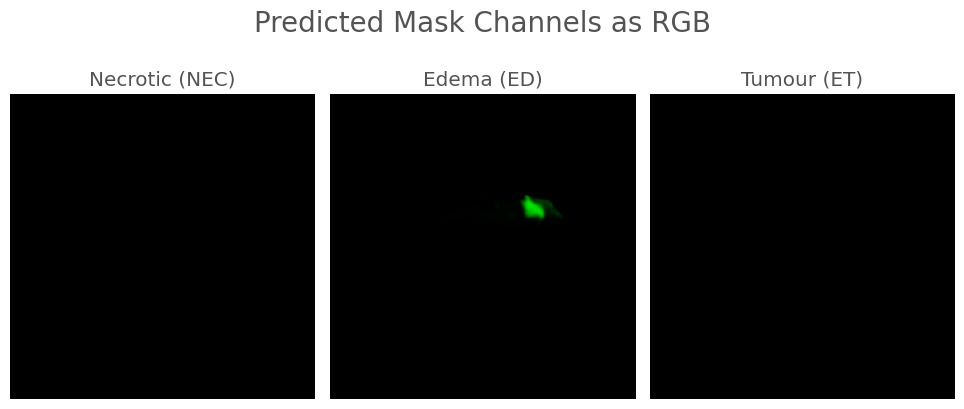

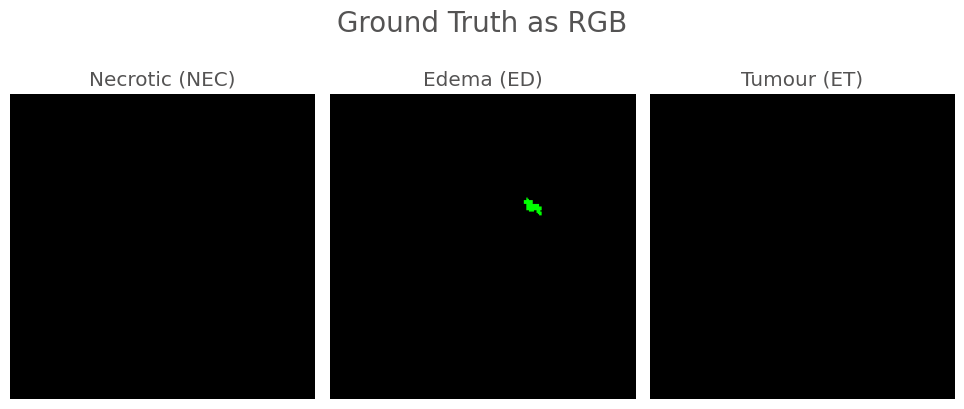

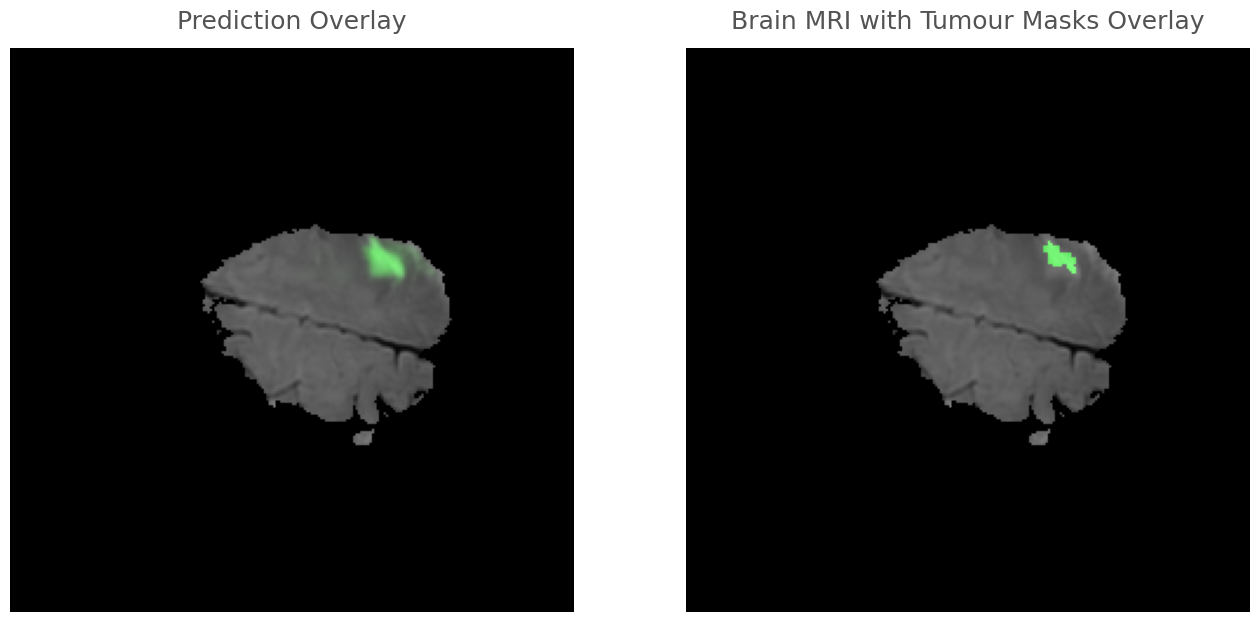

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet('LeakyReLU').to(device)
model = load_model(model, path='/content/BraTS_Thesis/models_weights/unet_weights.pth')

test_input, test_target = next(test_input_iterator)
test_sample_from_saved_model(model, test_input, test_target, device)

# **Attention UNet**

In [70]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels//2, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(in_channels//2),
            activation,
            nn.Conv2d(in_channels//2, out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class AttentionBlock(nn.Module):
    def __init__(self, gate_channels, connections_channels, intermediate_channels):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(gate_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(intermediate_channels)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(connections_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(intermediate_channels)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(intermediate_channels, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, x):
        g1 = self.W_g(gate)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return x * psi


class AttentionUNet(nn.Module):
    def __init__(self, activation_fun):
        super().__init__()

        in_channels  = 4
        out_channels = 3
        n_filters    = 32
        activation   = nn.ReLU()
        if activation_fun == 'LeakyReLU':
          activation = nn.LeakyReLU(negative_slope=0.1)
          print('Activation: Leaky ReLU')
        else:
            print('Activation: ReLU')

        # Up and downsampling
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        # Bottleneck
        self.bottleneck  = nn.Sequential(
            nn.Conv2d(8*n_filters, 16*n_filters, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(16*n_filters),
            activation,
            nn.Conv2d(16*n_filters,  8*n_filters, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(8*n_filters),
            activation
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(16*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock(8*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock(4*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock(2*n_filters, 1*n_filters, activation)

        # Output
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

        # Attention
        self.att_4 = AttentionBlock(8 * n_filters, 8 * n_filters, 4 * n_filters)
        self.att_3 = AttentionBlock(4 * n_filters, 4 * n_filters, 2 * n_filters)
        self.att_2 = AttentionBlock(2 * n_filters, 2 * n_filters, 1 * n_filters)
        self.att_1 = AttentionBlock(1 * n_filters, 1 * n_filters, n_filters // 2)

    def forward(self, x):
          # Encoder
          skip_1 = self.enc_block_1(x)
          x = self.downsample(skip_1)
          skip_2 = self.enc_block_2(x)
          x = self.downsample(skip_2)
          skip_3 = self.enc_block_3(x)
          x = self.downsample(skip_3)
          skip_4 = self.enc_block_4(x)
          x = self.downsample(skip_4)

          # Bottleneck
          x = self.bottleneck(x)

          # Decoder with Attention
          x = self.upsample(x)
          skip_4 = self.att_4(x, skip_4)
          x = torch.cat((x, skip_4), axis=1)
          x = self.dec_block_4(x)

          x = self.upsample(x)
          skip_3 = self.att_3(x, skip_3)
          x = torch.cat((x, skip_3), axis=1)
          x = self.dec_block_3(x)

          x = self.upsample(x)
          skip_2 = self.att_2(x, skip_2)
          x = torch.cat((x, skip_2), axis=1)
          x = self.dec_block_2(x)

          x = self.upsample(x)
          skip_1 = self.att_1(x, skip_1)
          x = torch.cat((x, skip_1), axis=1)
          x = self.dec_block_1(x)

          x = self.output(x)
          return x

In [ ]:
try:
    torch.cuda.empty_cache()
    del model
except NameError:
    pass

# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          50,
    'batch_size':        64,
    'learning_rate':     1e-3,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1
}

model = AttentionUNet('ReLU')
count_parameters(model)

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=True, model_saving=True)

**Prediction on saved model**

Activation: ReLU


<ipython-input-14-e79736d1c903>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


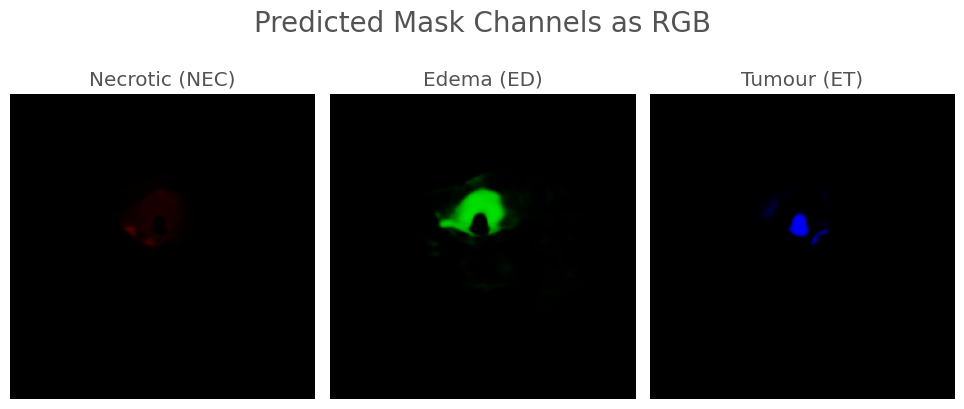

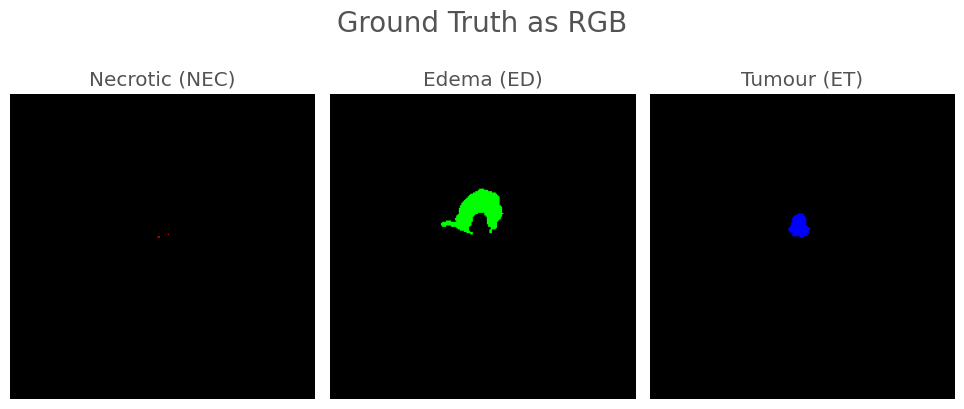

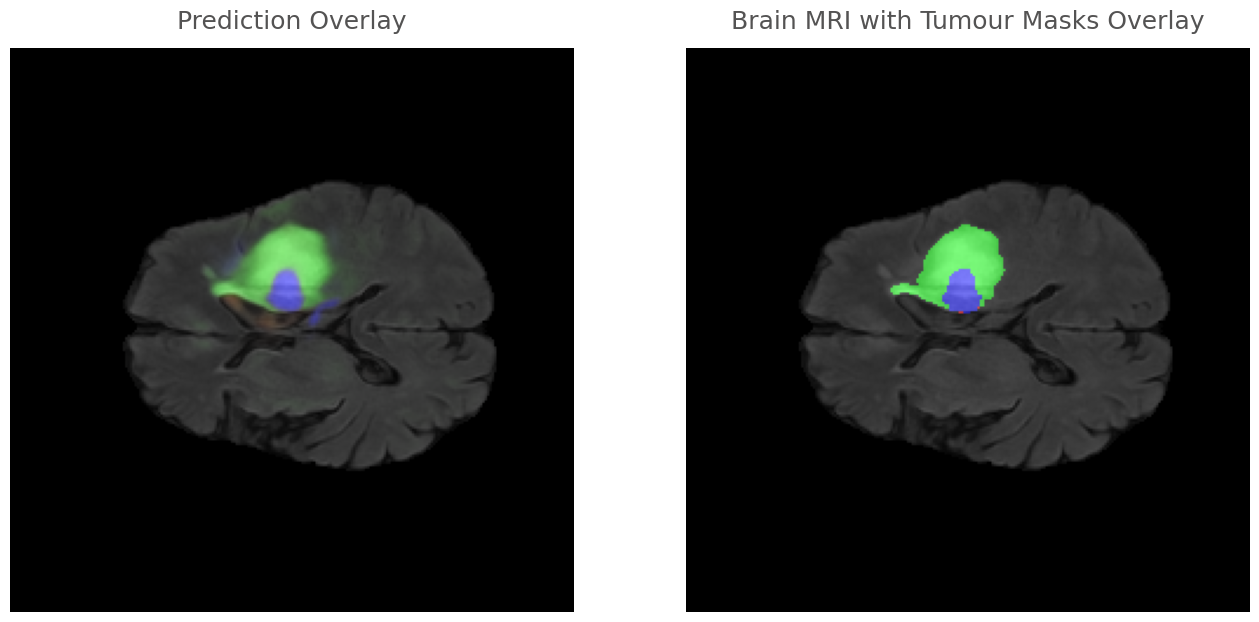

In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AttentionUNet('ReLU').to(device)
model = load_model(model, path='/content/BraTS_Thesis/models_weights/attention_unet_weights.pth')

test_input, test_target = next(test_input_iterator)
test_sample_from_saved_model(model, test_input, test_target, device)

# **Inverse Bottleneck in U-Net**

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU(), inverse=True):
        super().__init__()
        expansion_ratio = 4

        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=7, stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),

            nn.Conv2d(out_channels,                 out_channels, kernel_size=7, stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),
        )

    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU(), inverse=True):
        super().__init__()
        expansion_ratio = 4

        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,                    in_channels, kernel_size=7, stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels,    expansion_ratio*in_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*in_channels,   out_channels, kernel_size=(1,1), stride=1),

            nn.Conv2d(out_channels,                  out_channels, kernel_size=7, stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels,  out_channels, kernel_size=(1,1), stride=1),
        )

    def forward(self, x):
        return self.decoder_block(x)

class Inverse_UNet(nn.Module):
    def __init__(self, activation_fun):
        super().__init__()

        in_channels  = 4
        out_channels = 3
        n_filters    = 32
        activation   = nn.ReLU()
        if activation_fun == 'LeakyReLU':
          activation = nn.LeakyReLU(negative_slope=0.1)
          print('Activation: Leaky ReLU')
        else:
            print('Activation: ReLU')
        expansion_rate = 4

        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=7, stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, expansion_rate*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   expansion_rate*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),

            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=7, stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, expansion_rate*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   expansion_rate*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(8*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock(4*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock(2*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock(1*n_filters, 1*n_filters, activation)

        # Output
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

    def forward(self, x):
        # Encoder
        skip_1 = self.enc_block_1(x)
        x      = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x      = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x      = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x      = self.downsample(skip_4)

        # Bottleneck
        x      = self.bottleneck(x)

        # Decoder
        x      = self.upsample(x)
        x      = torch.add(x, skip_4)
        x      = self.dec_block_4(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_3)
        x      = self.dec_block_3(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_2)
        x      = self.dec_block_2(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_1)
        x      = self.dec_block_1(x)
        x      = self.output(x)
        return x

In [ ]:
try:
    torch.cuda.empty_cache()
    del model
except NameError:
    pass

# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          50,
    'batch_size':        64,
    'learning_rate':     1e-3,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1
}

model = Inverse_UNet('ReLU')
count_parameters(model)

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=True)

# **Seprate Convolution in UNet**

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()

        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=(1,1), stride=1),
            activation,

            nn.Conv2d(out_channels, out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=(1,1), stride=1),
            activation,
        )

    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()

        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=(1,1), stride=1),
            activation,

            nn.Conv2d(out_channels, out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=(1,1), stride=1),
            activation,
        )

    def forward(self, x):
        return self.decoder_block(x)


class Seprate_UNet(nn.Module):
    def __init__(self, activation_fun):
        super().__init__()

        in_channels  = 4
        out_channels = 3
        n_filters    = 32
        activation   = nn.ReLU()
        if activation_fun == 'LeakyReLU':
          activation = nn.LeakyReLU(negative_slope=0.1)
          print('Activation: Leaky ReLU')
        else:
            print('Activation: ReLU')

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=(1,1), stride=1),
            activation,

            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=(1,1), stride=1),
            activation,
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(8*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock(4*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock(2*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock(1*n_filters, 1*n_filters, activation)

        # Output
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

    def forward(self, x):
        # Encoder
        skip_1 = self.enc_block_1(x)
        x      = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x      = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x      = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x      = self.downsample(skip_4)

        # Bottleneck
        x      = self.bottleneck(x)

        # Decoder
        x      = self.upsample(x)
        x      = torch.add(x, skip_4)
        x      = self.dec_block_4(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_3)
        x      = self.dec_block_3(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_2)
        x      = self.dec_block_2(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_1)
        x      = self.dec_block_1(x)
        x      = self.output(x)
        return x

In [ ]:
try:
    torch.cuda.empty_cache()
    del model
except NameError:
    pass

# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          50,
    'batch_size':        64,
    'learning_rate':     1e-3,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1
}

model = Seprate_UNet('ReLU')
count_parameters(model)

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=True)

# **Transfer Learning**


**ResNet18**

In [14]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )

    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels//2, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(in_channels//2, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class UNetWithResNet(nn.Module):
    def __init__(self, activation_fun):
        super().__init__()

        in_channels  = 4
        out_channels = 3
        n_filters    = 32
        activation   = nn.ReLU()
        if activation_fun == 'LeakyReLU':
          activation = nn.LeakyReLU(negative_slope=0.1)
          print('Activation: Leaky ReLU')
        else:
            print('Activation: ReLU')

        # Pre-trained encoder (ResNet18)
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.encoder_pretrained = nn.Sequential(*list(resnet.children())[:-2])

        self.encoder_pretrained[0] = nn.Conv2d(
            in_channels, 64, kernel_size=(3, 3), stride=1, padding=1, bias=False
        )

        # Down and upsampling
        self.downsample = nn.MaxPool2d((2, 2), stride=2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(16* n_filters, 16* n_filters, kernel_size=(3, 3), stride=1, padding=1),
            activation,
            nn.Conv2d(16* n_filters, 16* n_filters, kernel_size=(3, 3), stride=1, padding=1),
            activation
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(24* n_filters, 4* n_filters, activation)
        self.dec_block_3 = DecoderBlock(8* n_filters, 2* n_filters, activation)
        self.dec_block_2 = DecoderBlock(4* n_filters, 1* n_filters, activation)
        self.dec_block_1 = DecoderBlock(3* n_filters, 1* n_filters, activation)

        # Output
        self.output = nn.Conv2d(32, out_channels, kernel_size=(1, 1), stride=1, padding=0)

    def forward(self, x):
        # Encoder (using pre-trained ResNet18)
        skip_1 = self.encoder_pretrained[0:3](x)
        skip_2 = self.encoder_pretrained[3:5](skip_1)
        skip_3 = self.encoder_pretrained[5](skip_2)
        skip_4 = self.encoder_pretrained[6](skip_3)
        x = self.encoder_pretrained[7](skip_4)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        x      = self.upsample(x)
        x      = torch.cat((x, skip_4), axis=1)
        x      = self.dec_block_4(x)

        x      = self.upsample(x)
        x      = torch.cat((x, skip_3), axis=1)
        x      = self.dec_block_3(x)

        x      = self.upsample(x)
        x      = torch.cat((x, skip_2), axis=1)
        x      = self.dec_block_2(x)

        x      = self.upsample(x)
        x      = torch.cat((x, skip_1), axis=1)
        x      = self.dec_block_1(x)

        x      = self.output(x)
        return x

In [ ]:
try:
    torch.cuda.empty_cache()
    del model
except NameError:
    pass

# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          50,
    'batch_size':        64,
    'learning_rate':     1e-3,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1
}

model = UNetWithResNet('LeakyReLU')
count_parameters(model)

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=True, loss_function='BCE')

**Prediction on saved model**

Activation: Leaky ReLU


<ipython-input-11-e79736d1c903>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


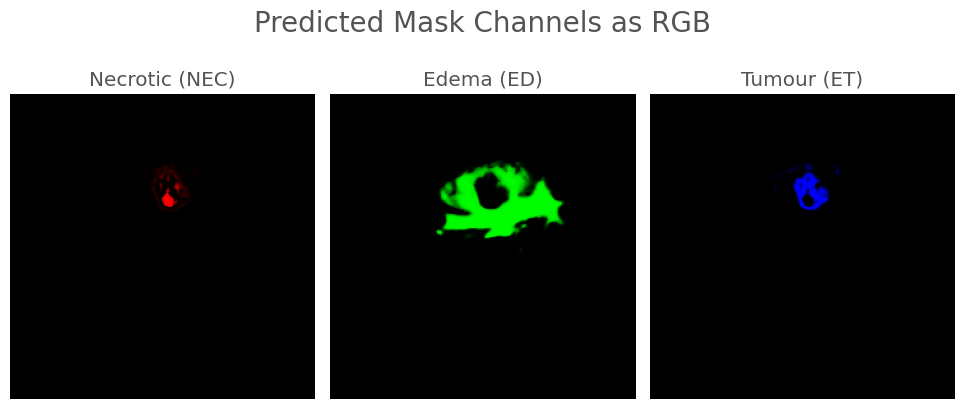

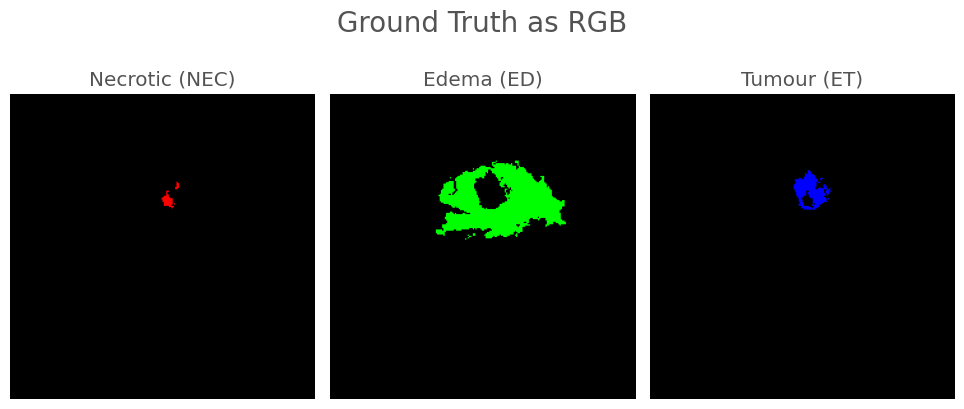

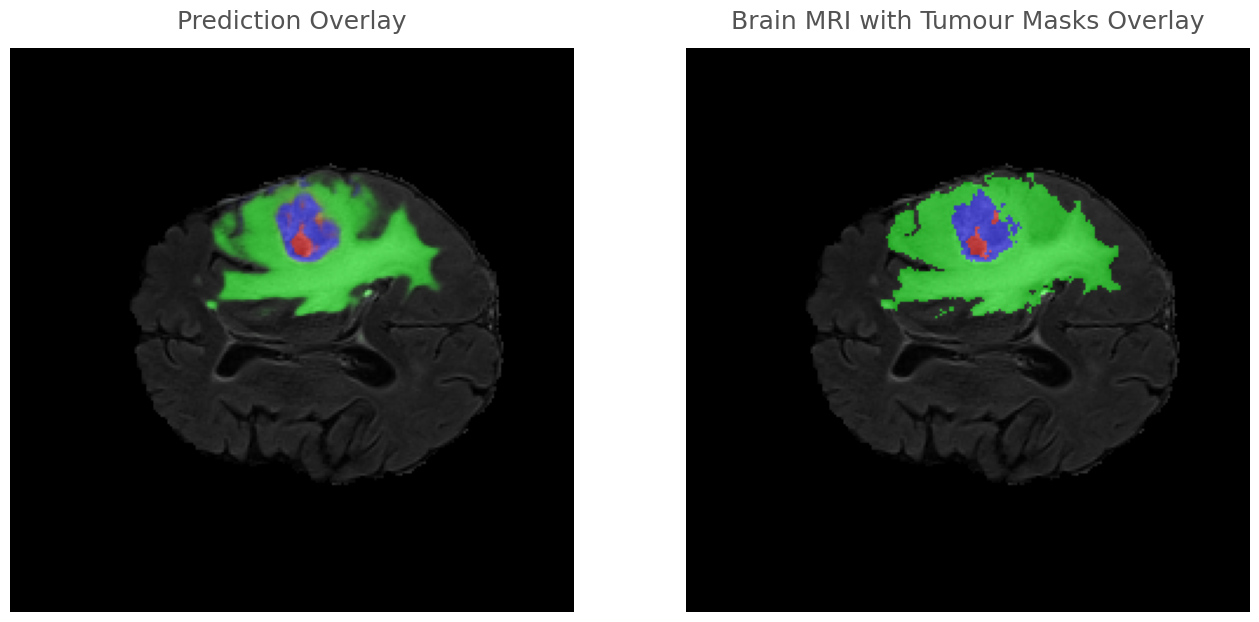

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNetWithResNet('LeakyReLU').to(device)  # Move model to device
model = load_model(model, path='/content/BraTS_Thesis/models_weights/resnet_unet_weights.pth')

test_input, test_target = next(test_input_iterator)  # Ensure this is a valid iterator
test_sample_from_saved_model(model, test_input, test_target, device)

**EfficientNet**

In [112]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )

    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels//2, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(in_channels//2, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class UNetWithTransferLearning(nn.Module):
    def __init__(self, activation_fun):
        super().__init__()

        # Config
        in_channels  = 4
        out_channels = 3
        n_filters    = 32
        activation   = nn.ReLU()
        if activation_fun == 'LeakyReLU':
          activation = nn.LeakyReLU(negative_slope=0.1)
          print('Activation: Leaky ReLU')
        else:
            print('Activation: ReLU')

        # Pre-trained encoder (EfficientNet)
        self.effnet = models.efficientnet_b0(pretrained=True)
        self.encoder1 = nn.Sequential(*list(self.effnet.features.children())[0])
        self.encoder1[0] = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.encoder2 = nn.Sequential(*list(self.effnet.features.children())[1])
        self.encoder3 = nn.Sequential(*list(self.effnet.features.children())[2])
        self.encoder4 = nn.Sequential(*list(self.effnet.features.children())[3])
        self.encoder5 = nn.Sequential(*list(self.effnet.features.children())[4])

        # Down and upsampling
        self.downsample = nn.MaxPool2d((2, 2), stride=2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(80, 80, kernel_size=(3, 3), stride=1, padding=1),
            activation,
            nn.Conv2d(80, 80, kernel_size=(3, 3), stride=1, padding=1),
            activation
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(120, 40, activation)
        self.dec_block_3 = DecoderBlock(64, 24, activation)
        self.dec_block_2 = DecoderBlock(40, 16, activation)
        self.dec_block_1 = DecoderBlock(48, 32, activation)

        # Output
        self.output = nn.Conv2d(32, out_channels, kernel_size=(1, 1), stride=1, padding=0)

    def forward(self, x):
        # Encoder
        skip_1 = self.encoder1(x)
        skip_2 = self.encoder2(skip_1)
        skip_3 = self.encoder3(skip_2)
        skip_4 = self.encoder4(skip_3)
        x = self.encoder5(skip_4)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        x      = self.upsample(x)
        x      = torch.cat((x, skip_4), axis=1)
        x      = self.dec_block_4(x)

        x      = self.upsample(x)
        x      = torch.cat((x, skip_3), axis=1)
        x      = self.dec_block_3(x)

        x      = self.upsample(x)
        x      = torch.cat((x, skip_2), axis=1)
        x      = self.dec_block_2(x)

        x      = self.upsample(x)
        x      = torch.cat((x, skip_1), axis=1)
        x      = self.dec_block_1(x)

        x      = self.output(x)
        return x

In [ ]:
try:
    torch.cuda.empty_cache()
    del model
except NameError:
    pass

# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          50,
    'batch_size':        64,
    'learning_rate':     1e-3,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1
}

model = UNetWithTransferLearning('LeakyReLU')
count_parameters(model)

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=True, loss_function='BCE')

# **Attention Modules**


**Channel Attention**

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels//2, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(in_channels//2),
            activation,
            nn.Conv2d(in_channels//2, out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class AttentionResBlock(nn.Module):
    def __init__(self, in_channels, activation=nn.ReLU()):
        super().__init__()
        self.query_conv     = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=1)
        self.key_conv       = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=2)
        self.attention_conv = nn.Conv2d(in_channels, 1, kernel_size=(1,1), stride=1)

        self.upsample       = nn.UpsamplingBilinear2d(scale_factor=2)
        self.activation     = activation

    def forward(self, query, key, value):
        query = self.query_conv(query)
        key   = self.key_conv(key)

        combined_attention = self.activation(query + key)
        attention_map = torch.sigmoid(self.attention_conv(combined_attention))
        upsampled_attention_map = self.upsample(attention_map)
        attention_scores = value * upsampled_attention_map
        return attention_scores

class SE_Block(nn.Module):
    def __init__(self, in_channels, reduction=16, activation=nn.ReLU()):
        super(SE_Block, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.activation = activation

    def forward(self, x):
        avg_pool = torch.mean(x, dim=[2, 3], keepdim=True)  # (B, C, 1, 1)

        excitation = self.fc1(avg_pool)
        excitation = self.activation(excitation)
        excitation = self.fc2(excitation)
        excitation = self.sigmoid(excitation)

        return x * excitation

class ChannelUNet(nn.Module):
    def __init__(self, activation_fun):
        super().__init__()

        in_channels  = 4
        out_channels = 3
        n_filters    = 32
        activation   = nn.ReLU()
        if activation_fun == 'LeakyReLU':
          activation = nn.LeakyReLU(negative_slope=0.1)
          print('Activation: Leaky ReLU')
        else:
            print('Activation: ReLU')

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        # Bottleneck
        self.bottleneck  = nn.Sequential(
            nn.Conv2d(8*n_filters, 16*n_filters, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(16*n_filters),
            activation,
            nn.Conv2d(16*n_filters,  8*n_filters, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(8*n_filters),
            activation
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(16*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock(8*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock(4*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock(2*n_filters, 1*n_filters, activation)

        # Output projection
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

        self.att_res_block_1 = AttentionResBlock(1*n_filters)
        self.att_res_block_2 = AttentionResBlock(2*n_filters)
        self.att_res_block_3 = AttentionResBlock(4*n_filters)
        self.att_res_block_4 = AttentionResBlock(8*n_filters)

         # Channel Attention Block
        self.channel_att_1 = SE_Block(2*n_filters)
        self.channel_att_2 = SE_Block(4*n_filters)
        self.channel_att_3 = SE_Block(8*n_filters)
        self.channel_att_4 = SE_Block(16*n_filters)

    def forward(self, x):
            #Encoder
            enc_1 = self.enc_block_1(x)
            x     = self.downsample(enc_1)
            enc_2 = self.enc_block_2(x)
            x     = self.downsample(enc_2)
            enc_3 = self.enc_block_3(x)
            x     = self.downsample(enc_3)
            enc_4 = self.enc_block_4(x)
            x     = self.downsample(enc_4)

            # Bottleneck
            dec_4 = self.bottleneck(x)

            # Decoder
            x     = self.upsample(dec_4)
            att_4 = self.att_res_block_4(dec_4, enc_4, enc_4)
            x     = torch.cat((x, att_4), axis=1)
            x     = self.channel_att_4(x)

            dec_3 = self.dec_block_4(x)
            x     = self.upsample(dec_3)
            att_3 = self.att_res_block_3(dec_3, enc_3, enc_3)
            x     = torch.cat((x, att_3), axis=1)
            x     = self.channel_att_3(x)

            dec_2 = self.dec_block_3(x)
            x     = self.upsample(dec_2)
            att_2 = self.att_res_block_2(dec_2, enc_2, enc_2)
            x     = torch.cat((x, att_2), axis=1)
            x     = self.channel_att_2(x)

            dec_1 = self.dec_block_2(x)
            x     = self.upsample(dec_1)
            att_1 = self.att_res_block_1(dec_1, enc_1, enc_1)
            x     = torch.cat((x, att_1), axis=1)
            x     = self.channel_att_1(x)

            x     = self.dec_block_1(x)
            x     = self.output(x)
            return x

In [ ]:
try:
    torch.cuda.empty_cache()
    del model
except NameError:
    pass

# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          50,
    'batch_size':        64,
    'learning_rate':     1e-3,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1
}

model = ChannelUNet('ReLU')
count_parameters(model)

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=True, loss_function='BCE')

**Spatial Attention**

In [106]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels//2, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(in_channels//2),
            activation,
            nn.Conv2d(in_channels//2, out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class SpatialAttentionBlock(nn.Module):
    def __init__(self, in_channels, activation=nn.ReLU()):
        super().__init__()
        self.query_conv     = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=1)
        self.key_conv       = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=2)
        self.attention_conv = nn.Conv2d(in_channels, 1, kernel_size=(1,1), stride=1)

        self.upsample       = nn.UpsamplingBilinear2d(scale_factor=2)
        self.activation     = activation

    def forward(self, query, key, value):
        query = self.query_conv(query)
        key   = self.key_conv(key)

        combined_attention = self.activation(query + key)
        attention_map = torch.sigmoid(self.attention_conv(combined_attention))
        upsampled_attention_map = self.upsample(attention_map)
        attention_scores = value * upsampled_attention_map
        return attention_scores


class SpatialUNet(nn.Module):
    def __init__(self, activation_fun):
        super().__init__()

        # Config
        in_channels  = 4
        out_channels = 3
        n_filters    = 32
        activation   = nn.ReLU()
        if activation_fun == 'LeakyReLU':
          activation = nn.LeakyReLU(negative_slope=0.1)
          print('Activation: Leaky ReLU')
        else:
            print('Activation: ReLU')

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        # Bottleneck
        self.bottleneck  = nn.Sequential(
            nn.Conv2d(8*n_filters, 16*n_filters, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(16*n_filters),
            activation,
            nn.Conv2d(16*n_filters,  8*n_filters, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(8*n_filters),
            activation
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(16*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock(8*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock(4*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock(2*n_filters, 1*n_filters, activation)

        # Output
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

        #Spatial Attention Mechanisms
        self.spatial_att_1 = SpatialAttentionBlock(1*n_filters)
        self.spatial_att_2 = SpatialAttentionBlock(2*n_filters)
        self.spatial_att_3 = SpatialAttentionBlock(4*n_filters)
        self.spatial_att_4 = SpatialAttentionBlock(8*n_filters)

    def forward(self, x):
            #Encoder
            enc_1 = self.enc_block_1(x)
            x     = self.downsample(enc_1)
            enc_2 = self.enc_block_2(x)
            x     = self.downsample(enc_2)
            enc_3 = self.enc_block_3(x)
            x     = self.downsample(enc_3)
            enc_4 = self.enc_block_4(x)
            x     = self.downsample(enc_4)

            # Bottleneck
            dec_4 = self.bottleneck(x)

            # Decoder
            x     = self.upsample(dec_4)
            att_4 = self.spatial_att_4(dec_4, enc_4, enc_4)
            x     = torch.cat((x, att_4), axis=1)

            dec_3 = self.dec_block_4(x)
            x     = self.upsample(dec_3)
            att_3 = self.spatial_att_3(dec_3, enc_3, enc_3)
            x     = torch.cat((x, att_3), axis=1)

            dec_2 = self.dec_block_3(x)
            x     = self.upsample(dec_2)
            att_2 = self.spatial_att_2(dec_2, enc_2, enc_2)
            x     = torch.cat((x, att_2), axis=1)

            dec_1 = self.dec_block_2(x)
            x     = self.upsample(dec_1)
            att_1 = self.spatial_att_1(dec_1, enc_1, enc_1)
            x     = torch.cat((x, att_1), axis=1)

            x     = self.dec_block_1(x)
            x     = self.output(x)
            return x

In [ ]:
try:
    torch.cuda.empty_cache()
    del model
except NameError:
    pass


# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          50,
    'batch_size':        64,
    'learning_rate':     1e-3,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1
}

model = SpatialUNet('ReLU')
count_parameters(model)

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=True, loss_function='BCE')

**Multi-Head**

In [ ]:
from math import sqrt

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / sqrt(self.d_k)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        attn_probs = F.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, num_heads, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels//2, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(in_channels//2),
            activation,
            nn.Conv2d(in_channels//2, out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class MultiHeadSpatialAttention(nn.Module):
    def __init__(self, in_channels, num_heads):
        super().__init__()
        self.in_channels = in_channels
        self.num_heads = num_heads
        self.mha = MultiHeadAttention(d_model=in_channels, num_heads=num_heads)
        self.proj = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 1))
        self.flatten = nn.Flatten(2)

    def forward(self, query, key, value):

        B, C, H, W = query.size()
        query_seq = query.view(B, C, -1).permute(0, 2, 1)
        key_seq = key.view(B, C, -1).permute(0, 2, 1)
        value_seq = value.view(B, C, -1).permute(0, 2, 1)

        attn_output = self.mha(query_seq, key_seq, value_seq)

        attn_output = attn_output.permute(0, 2, 1).view(B, C, H, W)
        return self.proj(attn_output)

class MultiHeadUNet(nn.Module):
    def __init__(self, activation_fun):
        super().__init__()

        # Config
        in_channels  = 4
        out_channels = 3
        n_filters    = 32
        activation   = nn.ReLU()
        if activation_fun == 'LeakyReLU':
          activation = nn.LeakyReLU(negative_slope=0.1)
          print('Activation: Leaky ReLU')
        else:
            print('Activation: ReLU')
        num_heads = 4

        # Up and downsampling
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        # Bottleneck
        self.bottleneck  = nn.Sequential(
            nn.Conv2d(8*n_filters, 16*n_filters, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(16*n_filters),
            activation,
            nn.Conv2d(16*n_filters,  8*n_filters, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(8*n_filters),
            activation
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(16*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock(8*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock(4*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock(2*n_filters, 1*n_filters, activation)

        # Output
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

        self.attention_1 = MultiHeadSpatialAttention(1 * n_filters, num_heads)
        self.attention_2 = MultiHeadSpatialAttention(2 * n_filters, num_heads)
        self.attention_3 = MultiHeadSpatialAttention(4 * n_filters, num_heads)
        self.attention_4 = MultiHeadSpatialAttention(8 * n_filters, num_heads)

    def forward(self, x):
            #Encoder
            enc_1 = self.enc_block_1(x)
            x     = self.downsample(enc_1)
            enc_2 = self.enc_block_2(x)
            x     = self.downsample(enc_2)
            enc_3 = self.enc_block_3(x)
            x     = self.downsample(enc_3)
            enc_4 = self.enc_block_4(x)
            x     = self.downsample(enc_4)

            # Bottleneck
            dec_4 = self.bottleneck(x)

            # Decoder
            x     = self.upsample(dec_4)
            att_4 = self.attention_4(dec_4, enc_4, enc_4)
            att_4 = self.upsample(att_4)
            x     = torch.cat((x, att_4), axis=1)

            dec_3 = self.dec_block_4(x)
            x     = self.upsample(dec_3)
            att_3 = self.attention_3(dec_3, enc_3, enc_3)
            att_3 = self.upsample(att_3)
            x     = torch.cat((x, att_3), axis=1)

            dec_2 = self.dec_block_3(x)
            x     = self.upsample(dec_2)
            att_2 = self.attention_2(dec_2, enc_2, enc_2)
            att_2 = self.upsample(att_2)
            x     = torch.cat((x, att_2), axis=1)

            dec_1 = self.dec_block_2(x)
            x     = self.upsample(dec_1)
            att_1 = self.attention_1(dec_1, enc_1, enc_1)
            att_1 = self.upsample(att_1)
            x     = torch.cat((x, att_1), axis=1)

            x     = self.dec_block_1(x)
            x     = self.output(x)
            return x

In [ ]:
try:
    torch.cuda.empty_cache()
    del model
except NameError:
    pass

# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          50,
    'batch_size':        64,
    'learning_rate':     1e-3,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1
}

model = MultiHeadUNet('ReLU')
count_parameters(model)

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=True, loss_function='BCE')